In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.fftpack import fft
from statsmodels.tsa.stattools import adfuller
from scipy.signal import find_peaks
from hmmlearn.hmm import GaussianHMM
from datetime import datetime
from sklearn.metrics import mean_squared_error


In [82]:
# Load the dataset (modify file path accordingly)
file_path = "Cours_titres.xlsx"
df = pd.read_excel(file_path, index_col=0, parse_dates=True)

# Handle missing values by forward-filling and back-filling
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)


In [ ]:
# Convert prices to log-returns for better trend analysis
log_returns = np.log(df / df.shift(1)).dropna()

# Standardize the data (PCA works best on normalized data)
scaler = StandardScaler()
log_returns_scaled = scaler.fit_transform(log_returns)

# Perform PCA
pca = PCA(n_components=5)  # Extract top 5 components
pca.fit(log_returns_scaled)

In [3]:
# Explained variance by each principal component
explained_variance = pca.explained_variance_ratio_

# Contribution of each stock to the first principal component (key trend)
top_trend = pca.components_[0]  # First eigenvector
stock_contributions = pd.Series(top_trend, index=df.columns)

# Rank stocks by contribution to the main trend
top_stocks = stock_contributions.abs().sort_values(ascending=False)

# Select top stocks for investment (most aligned with the main trend)
recommended_stocks = top_stocks.head(5).index.tolist()



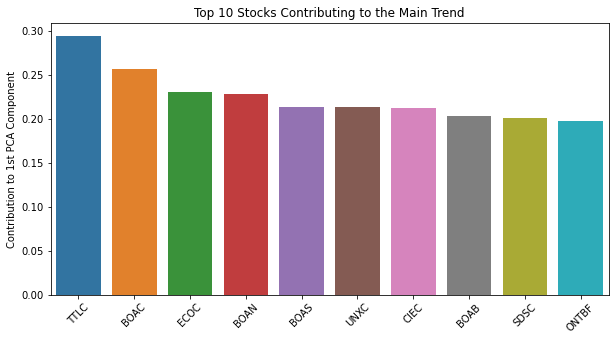

📈 Explained Variance by Principal Components: [0.04562968 0.02842192 0.02588145 0.02487762 0.02422437]
✅ Recommended Stocks to Invest: ['TTLC', 'BOAC', 'ECOC', 'BOAN', 'BOAS']


In [4]:
# 📊 Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x=top_stocks.head(10).index, y=top_stocks.head(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 Stocks Contributing to the Main Trend")
plt.ylabel("Contribution to 1st PCA Component")
plt.show()

# Output results
print("📈 Explained Variance by Principal Components:", explained_variance)
print("✅ Recommended Stocks to Invest:", recommended_stocks)


In [10]:
# Periodicity Detection with Robust Error Handling
def detect_periodicity(data):
    """Detects periodicity in stock price movements using Fourier Transform."""
    data = data.dropna()  # Remove NaNs
    if len(data) < 10:  # Not enough data for Fourier Transform
        return None
    
    fft_vals = np.abs(fft(data - np.mean(data)))  # FFT on detrended data
    frequencies = np.fft.fftfreq(len(data))
    
    # Find the dominant frequency (ignoring zero frequency)
    dominant_freq_idx = np.argmax(fft_vals[1:]) + 1  # Skip first element (trend)
    dominant_freq = frequencies[dominant_freq_idx]
    
    # Convert frequency to period (number of days)
    return 1 / dominant_freq if dominant_freq > 0 else None

# Apply the function to all stocks
periodicity_results = {}
for stock in df.columns:
    try:
        periodicity_results[stock] = detect_periodicity(df[stock])
    except Exception as e:
        # print(f"⚠️ Error processing {stock}: {e}")
        periodicity_results[stock] = None  # Default to None if error occurs


In [ ]:
### 1️⃣ Periodicity Analysis (Fourier Transform)
def detect_periodicity(data):
    fft_vals = np.abs(fft(data - np.mean(data)))
    frequencies = np.fft.fftfreq(len(data))
    dominant_freq = frequencies[np.argmax(fft_vals[1:]) + 1]  # Ignore zero frequency
    return 1 / dominant_freq if dominant_freq > 0 else None

periodicity_results = {stock: detect_periodicity(df[stock].dropna()) for stock in df.columns}

In [12]:


### 2️⃣ Correlation Analysis
correlation_matrix = log_returns.corr()

### 3️⃣ Optimal Investment Timing (Rolling Sharpe Ratio)
def rolling_sharpe_ratio(returns, window=252):  # 252 trading days ≈ 1 year
    return (returns.rolling(window).mean() / returns.rolling(window).std()).dropna()

sharpe_ratios = {stock: rolling_sharpe_ratio(log_returns[stock]) for stock in df.columns}

### 4️⃣ Identify Best Entry Points (Local Minima Detection)
def detect_best_entry_points(series, threshold=0.02):
    prices = series.dropna()
    peaks, _ = find_peaks(-prices, prominence=threshold)  # Find local minima
    return prices.iloc[peaks].index

entry_points = {stock: detect_best_entry_points(df[stock]) for stock in df.columns}



In [20]:
# Output results
# print("📈 Explained Variance by Principal Components:", explained_variance)
# print("✅ Recommended Stocks to Invest:", recommended_stocks)
# print("🔄 Stock Periodicity (Days):", periodicity_results)
print("📉 Best Investment Timing (Local Minima):")
best_time = pd.DataFrame({k: v[:3] for k, v in entry_points.items()})
display(best_time.head())
print("📊 Correlation Matrix:\n")
correlation_matrix.head()

📉 Best Investment Timing (Local Minima):


,ABJC,BICC,BNBC,BOAB,BOABF,BOAC,BOAM,BOAN,BOAS,CABC,...,SNTS,SOGC,SPHC,STAC,STBC,SVOC,TTLC,TTLS,UNLC,UNXC
0,2013-01-11,2013-02-12,2013-01-09,2013-01-16,2013-01-23,2013-01-08,2016-06-23,2013-01-18,2014-12-24,2013-01-21,...,2013-01-08,2013-01-17,2013-01-04,2013-03-05,2013-01-03,2013-01-23,2013-02-05,2015-03-27,2013-03-21,2013-07-03
1,2013-01-30,2013-03-22,2013-01-18,2013-03-11,2013-02-06,2013-02-11,2016-06-30,2013-01-23,2015-01-08,2013-02-19,...,2013-01-23,2013-01-31,2013-01-15,2013-05-07,2013-01-09,2013-09-23,2013-03-27,2015-04-17,2013-04-19,2013-09-18
2,2013-02-19,2013-05-17,2013-03-14,2013-04-11,2013-03-19,2013-03-04,2016-07-04,2013-01-29,2015-01-13,2013-02-26,...,2013-01-31,2013-02-20,2013-01-21,2013-06-17,2013-01-15,2013-10-04,2013-04-18,2015-04-23,2013-06-07,2013-10-09


📊 Correlation Matrix:



,ABJC,BICC,BNBC,BOAB,BOABF,BOAC,BOAM,BOAN,BOAS,CABC,...,SNTS,SOGC,SPHC,STAC,STBC,SVOC,TTLC,TTLS,UNLC,UNXC
ABJC,1.000000,-0.000884,0.034920,0.002612,0.017708,0.033081,0.020929,-0.002880,0.010122,0.009919,...,0.006391,-0.010536,0.031536,0.063977,0.033359,0.025515,0.026493,-0.033610,0.012806,0.012934
BICC,-0.000884,1.000000,0.003966,0.019728,0.001383,0.022621,-0.016600,0.000137,0.030133,-0.002868,...,0.003183,0.033861,0.026207,0.029603,0.040661,0.051442,0.037992,0.041219,-0.002683,-0.045140
BNBC,0.034920,0.003966,1.000000,0.004495,0.022986,0.040873,0.004983,0.023280,0.028599,0.022301,...,-0.039083,0.017261,0.045480,0.036819,0.030674,0.041212,0.014052,0.026442,0.011541,0.022855
BOAB,0.002612,0.019728,0.004495,1.000000,0.130010,0.114967,0.042200,0.112260,0.092131,0.006158,...,0.024648,0.006491,0.022139,0.008575,0.036045,0.012921,0.057605,0.017267,0.038975,0.000635
BOABF,0.017708,0.001383,0.022986,0.130010,1.000000,0.107438,0.068110,0.079179,0.100477,0.029881,...,0.020009,0.014392,-0.015074,0.000232,0.032650,0.025050,0.031111,0.010818,-0.008017,0.024716


In [24]:
log_returns

,ABJC,BICC,BNBC,BOAB,BOABF,BOAC,BOAM,BOAN,BOAS,CABC,...,STBC,SVOC,TTLC,TTLS,UNLC,UNXC,Week,Month,Quarter,Semester
Date/Société,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,...,-0.000230,0.000000,0.010811,0.000000,0.000000,0.000000,1,1,1,1
2013-01-04,0.000000,0.002729,0.000000,0.000000,0.004535,0.013967,0.000000,0.000000,0.000000,0.000000,...,0.005961,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1
2013-01-07,0.000000,0.008141,0.000000,0.000000,0.000000,0.012405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,1,1
2013-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026372,0.000000,-0.005115,0.000000,0.000000,...,-0.005731,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,1,1
2013-01-09,0.000000,0.000000,-0.040822,0.000000,0.000000,0.045369,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001249,0.005362,0.000000,0.000000,0.000000,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,0.027399,-0.002817,-0.062370,0.011834,0.000000,0.000000,-0.009456,0.001668,0.000000,-0.012579,...,0.040322,0.000000,0.001388,0.000000,0.000000,-0.012121,11,3,1,1
2025-03-13,-0.027399,-0.003140,0.053024,-0.023811,-0.001159,-0.003515,0.011807,0.013245,0.031322,-0.029981,...,-0.001001,0.000000,-0.015374,0.037583,0.072231,0.012121,11,3,1,1
2025-03-14,0.000000,0.003140,0.000000,0.011976,0.009238,0.003515,0.000000,-0.043704,0.000000,0.071309,...,-0.000501,0.000000,0.027780,0.000000,0.005731,0.000000,11,3,1,1


In [23]:
# Extract seasonality periods
log_returns['Week'] = log_returns.index.isocalendar().week
log_returns['Month'] = log_returns.index.month
log_returns['Quarter'] = log_returns.index.quarter
log_returns['Semester'] = np.where(log_returns['Month'] <= 6, 1, 2)  # 1st or 2nd semester

# Compute average returns
weekly_avg_returns = log_returns.groupby("Week").mean().mean(axis=1)
monthly_avg_returns = log_returns.groupby("Month").mean().mean(axis=1)
quarterly_avg_returns = log_returns.groupby("Quarter").mean().mean(axis=1)
semiannual_avg_returns = log_returns.groupby("Semester").mean().mean(axis=1)


In [26]:
semiannual_avg_returns

Semester
1    0.363346
2    1.046125
dtype: float64

In [36]:
pd.DataFrame(monthly_returns)

,ABJC,BICC,BNBC,BOAB,BOABF,BOAC,BOAM,BOAN,BOAS,CABC,...,STAC,STBC,SVOC,TTLC,TTLS,UNLC,UNXC,Week,Quarter,Semester
Month,,,,,,,,,,,,,,,,,,,,,
1,-0.002011,-0.003119,-0.000087,-0.000176,-0.000396,-0.000783,-0.000452,-0.000302,-0.000453,0.001623,...,0.002442,-0.000502,-0.000679,-0.003465,-0.003043,0.000468,-0.000610,2.949821,1.0,1.0
2,-0.001335,-0.001004,0.000321,0.004501,0.002886,0.002324,0.000194,0.002729,0.000507,0.002949,...,0.001012,-0.000695,0.002166,0.001069,0.002448,0.000035,-0.000402,7.114943,1.0,1.0
3,0.001284,-0.000130,0.000986,0.001366,0.003037,0.002661,-0.000751,0.002741,0.002189,-0.004634,...,0.002304,-0.001120,0.000377,-0.000569,0.001401,-0.001488,0.001338,11.268116,1.0,1.0
4,0.001899,-0.000964,-0.000578,0.000888,-0.000789,-0.000049,0.001785,0.000829,-0.000610,-0.001701,...,0.000442,0.002679,0.001142,0.000111,-0.000139,0.002515,-0.000311,15.668,2.0,1.0
5,0.000646,0.000084,-0.000671,-0.004456,-0.003503,-0.000301,-0.002804,-0.003268,0.000569,0.002860,...,0.002230,0.002395,0.000322,0.001215,-0.000621,-0.000076,0.005458,20.056911,2.0,1.0
6,0.004394,0.001921,0.001829,0.001198,0.000948,0.001088,0.004423,-0.000259,0.000417,0.000740,...,-0.001435,0.000691,-0.000264,0.003908,0.001442,-0.001981,0.001623,24.392713,2.0,1.0
7,0.000444,-0.001026,-0.000146,0.000017,-0.000436,-0.001353,0.001756,-0.001542,0.000607,-0.000939,...,0.001194,-0.001361,-0.000694,0.000670,-0.001610,0.000479,-0.000333,28.725869,3.0,2.0
8,0.000103,-0.000429,-0.000193,0.001257,0.001606,0.000379,-0.000422,-0.000436,0.001826,-0.000552,...,-0.002483,-0.000554,-0.001240,-0.000948,-0.000673,-0.002001,0.000343,33.195219,3.0,2.0
9,-0.001324,0.001094,-0.003457,0.001282,-0.000197,-0.001057,-0.003171,-0.000386,-0.000203,-0.001250,...,0.001683,-0.000009,-0.000430,-0.001314,-0.000283,0.000994,-0.000190,37.531496,3.0,2.0


C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128197 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128198 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128197 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128198 missing fr

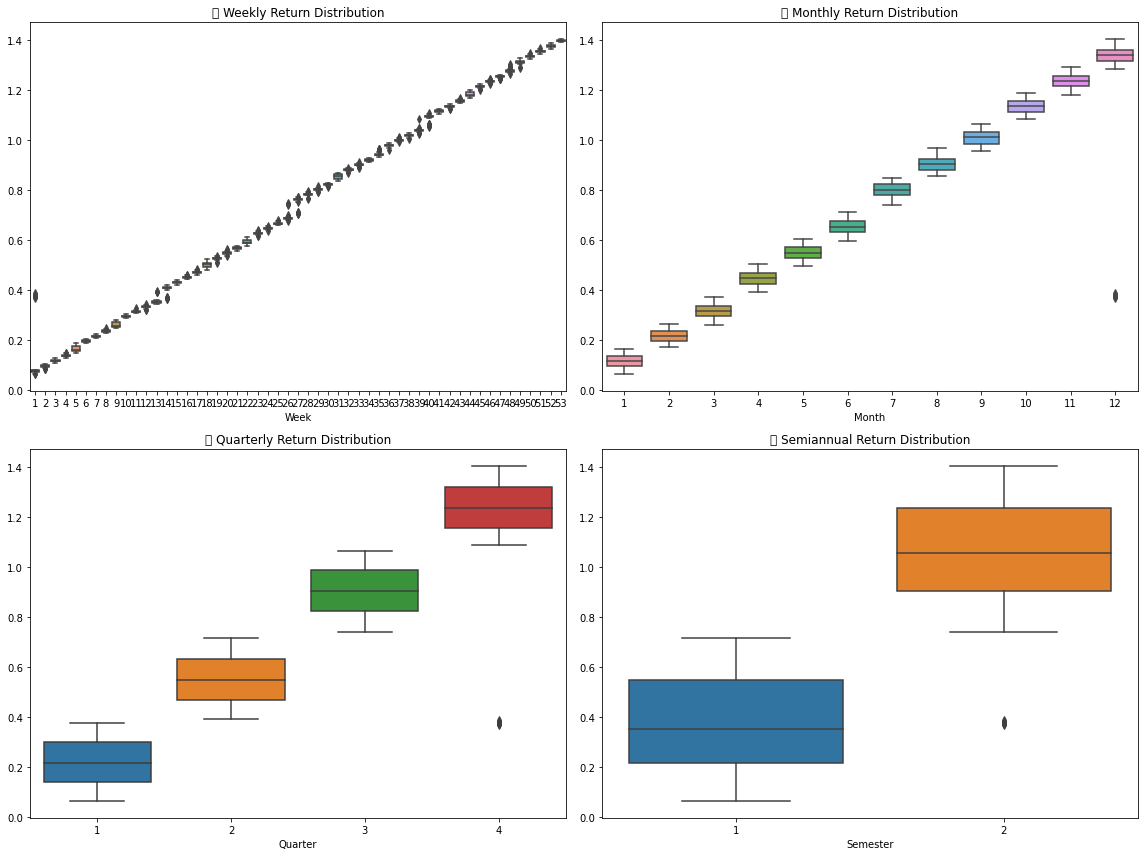

📈 Best Week to Invest: 53
📆 Best Month to Invest: 12
📊 Best Quarter to Invest: 4
🗓️ Best Semiannual Period to Invest: 2


In [37]:
# 📊 Boxplots for Seasonality
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Weekly Returns
sns.boxplot(x=log_returns['Week'], y=log_returns.mean(axis=1), ax=axes[0, 0])
axes[0, 0].set_title("📅 Weekly Return Distribution")
axes[0, 0].set_xlabel("Week")

# Monthly Returns
sns.boxplot(x=log_returns['Month'], y=log_returns.mean(axis=1), ax=axes[0, 1])
axes[0, 1].set_title("📆 Monthly Return Distribution")
axes[0, 1].set_xlabel("Month")

# Quarterly Returns
sns.boxplot(x=log_returns['Quarter'], y=log_returns.mean(axis=1), ax=axes[1, 0])
axes[1, 0].set_title("📊 Quarterly Return Distribution")
axes[1, 0].set_xlabel("Quarter")

# Semiannual Returns
sns.boxplot(x=log_returns['Semester'], y=log_returns.mean(axis=1), ax=axes[1, 1])
axes[1, 1].set_title("🗓️ Semiannual Return Distribution")
axes[1, 1].set_xlabel("Semester")

plt.tight_layout()
plt.show()

# 🏆 Best Time to Invest
best_week = weekly_avg_returns.idxmax()
best_month = monthly_avg_returns.idxmax()
best_quarter = quarterly_avg_returns.idxmax()
best_semiannual = semiannual_avg_returns.idxmax()

# ✅ Results
print("📈 Best Week to Invest:", best_week)
print("📆 Best Month to Invest:", best_month)
print("📊 Best Quarter to Invest:", best_quarter)
print("🗓️ Best Semiannual Period to Invest:", best_semiannual)


In [ ]:
# 🔥 Heatmap of Monthly Seasonality
monthly_returns = log_returns.groupby("Month").mean()
monthly_returns = monthly_returns.dropna(axis=1, how='all')
plt.figure(figsize=(10, 5))
sns.heatmap(monthly_returns, cmap="coolwarm", annot=False)
plt.title("📊 Monthly Stock Return Seasonality")
plt.xlabel("Stock")
plt.ylabel("Month")
plt.show()


## HMM Model

Model is not converging.  Current: 17799.32823181238 is not greater than 17799.39123482621. Delta is -0.0630030138308939
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\charl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128202 missing from current font.
  font.set_text(s, 0, flags=flags)


3078
3087 3088
3078
3087 3088
3078
3087 3088


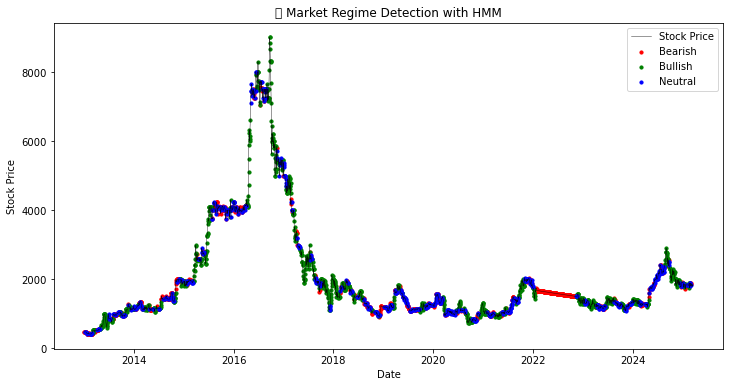

📌 Regime 0 (Bearish):
  ➡️ Mean Return: -0.0003
  🔄 Volatility: 0.0140

📌 Regime 1 (Bullish):
  ➡️ Mean Return: 0.0011
  🔄 Volatility: 0.0400

📌 Regime 2 (Neutral):
  ➡️ Mean Return: 0.0005
  🔄 Volatility: 0.0228



In [68]:
# 📈 Choose a benchmark stock (or average market index)
stock = df.iloc[:, 0]  # First column (modify if needed)

# 🔢 Compute log returns
returns = np.log(stock / stock.shift(1)).dropna()

# 🎯 Compute volatility (Rolling Standard Deviation)
volatility = returns.rolling(window=10).std()

# 📊 Prepare Feature Matrix (Log Returns + Volatility)
X = np.column_stack([returns, volatility])
X = X[~np.isnan(X).any(axis=1)]  # Drop NaN values

# 🔥 Fit HMM Model (3 regimes: Bull, Bear, Neutral)
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
# Create weights for recent observations
# decay_weights = np.exp(-np.arange(len(df))/10)  # Exponentially decaying weights
# emission_probs_weighted = hmm.predict_proba(df['log_return'].values.reshape(-1, 1)) * decay_weights[:, None]

hmm.fit(X)

# 🎭 Predict Market Regimes
hidden_states = hmm.predict(X)

# 🎨 Define colors for each regime
colors = ["red", "green", "blue"]
state_labels = ["Bearish", "Bullish", "Neutral"]

# 📈 Plot Stock Price with Regimes
plt.figure(figsize=(12, 6))
for i in range(hmm.n_components):
    mask = hidden_states == i
    plt.scatter(returns.index[list(mask)+abs(len(returns.index)-len(mask))*[False]], stock.iloc[list(mask)+abs(len(stock)-len(mask))*[False]], 
                color=colors[i], label=state_labels[i], s=10)

plt.plot(stock, color="black", linewidth=0.5, alpha=0.8, label="Stock Price")
plt.legend()
plt.title("📊 Market Regime Detection with HMM")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

# 🏆 Print Mean & Volatility of Each Regime
for i in range(hmm.n_components):
    print(f"📌 Regime {i} ({state_labels[i]}):")
    print(f"  ➡️ Mean Return: {hmm.means_[i][0]:.4f}")
    print(f"  🔄 Volatility: {hmm.means_[i][1]:.4f}\n")


In [90]:
# 🎯 Create a list of stocks to analyze
stocks = df.columns  # All stock tickers in the dataset

# 🔥 Initialize a dictionary to store the selected stocks for each regime
selected_stocks = {'Bearish': [], 'Bullish': [], 'Neutral': []}

# 📊 Loop through each stock and analyze its regime
for stock in stocks:
    stock_data = df[stock]

    # 🔢 Compute log returns
    returns = np.log(stock_data / stock_data.shift(1)).dropna()

    # 🎯 Compute volatility (Rolling Standard Deviation)
    volatility = returns.rolling(window=10).std()

    # 📊 Prepare Feature Matrix (Log Returns + Volatility)
    X = np.column_stack([returns, volatility])
    X = X[~np.isnan(X).any(axis=1)]  # Drop NaN values

    # 🔥 Fit HMM Model (3 regimes: Bull, Bear, Neutral)
    hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000)
    hmm.fit(X)

    # 🎭 Predict Market Regimes
    hidden_states = hmm.predict(X)

    # 🎨 Calculate mean return and volatility for each regime
    regime_stats = {}
    for i in range(hmm.n_components):
        mask = list(hidden_states == i)
        mean_return = returns.iloc[mask+abs(len(returns)-len(mask))*[False]].mean()
        mean_volatility = volatility.iloc[mask+abs(len(volatility)-len(mask))*[False]].mean()
        regime_stats[i] = {'mean_return': mean_return, 'mean_volatility': mean_volatility}

    # 💡 Assign the stock to its most dominant regime
    max_regime = max(regime_stats, key=lambda x: regime_stats[x]['mean_return'])  # Maximum mean return regime

    # Store the stock with its regime
    if max_regime == 0:
        selected_stocks['Bearish'].append((stock, regime_stats[max_regime]))
    elif max_regime == 1:
        selected_stocks['Bullish'].append((stock, regime_stats[max_regime]))
    else:
        selected_stocks['Neutral'].append((stock, regime_stats[max_regime]))

# 🔥 Sort stocks by mean return and volatility within each regime
for regime in selected_stocks:
    selected_stocks[regime] = sorted(selected_stocks[regime], key=lambda x: (x[1]['mean_return'], x[1]['mean_volatility']), reverse=True)[:10]

# 📊 Display Top 10 Stocks for Each Regime
for regime, stocks_info in selected_stocks.items():
    print(f"Top 10 Stocks in {regime} Regime:")
    for stock, stats in stocks_info:
        print(f"  - {stock}: Mean Return = {stats['mean_return']:.4f}, Volatility = {stats['mean_volatility']:.4f}")
    print("\n")

Model is not converging.  Current: 17799.24457324668 is not greater than 17799.334561048847. Delta is -0.08998780216643354
Model is not converging.  Current: 19155.48027613265 is not greater than 19155.494973753182. Delta is -0.0146976205323881
Model is not converging.  Current: 20750.110992728736 is not greater than 20750.557804169333. Delta is -0.4468114405972301
Model is not converging.  Current: 19466.071435865968 is not greater than 19466.361641958145. Delta is -0.2902060921769589
Model is not converging.  Current: 18690.934941379113 is not greater than 18691.184747024516. Delta is -0.24980564540237538
Model is not converging.  Current: 17434.100834619465 is not greater than 17434.12922581871. Delta is -0.028391199244651943
Model is not converging.  Current: 23529.131720072244 is not greater than 23530.661966020325. Delta is -1.5302459480808466
Model is not converging.  Current: 22931.411085013955 is not greater than 22933.841678391374. Delta is -2.4305933774194273
Model is not co

Top 10 Stocks in Bearish Regime:
  - SMBC: Mean Return = 0.0021, Volatility = 0.0308
  - BOAB: Mean Return = 0.0019, Volatility = 0.0230
  - BOAN: Mean Return = 0.0017, Volatility = 0.0255
  - SGBC: Mean Return = 0.0015, Volatility = 0.0252
  - SIBC: Mean Return = 0.0014, Volatility = 0.0206
  - ECOC: Mean Return = 0.0006, Volatility = 0.0263
  - CIEC: Mean Return = 0.0005, Volatility = 0.0284
  - ETIT: Mean Return = 0.0004, Volatility = 0.0283
  - SPHC: Mean Return = 0.0002, Volatility = 0.0294


Top 10 Stocks in Bullish Regime:
  - BOAC: Mean Return = 0.0036, Volatility = 0.0287
  - ORAC: Mean Return = 0.0030, Volatility = 0.0158
  - STBC: Mean Return = 0.0024, Volatility = 0.0268
  - BOABF: Mean Return = 0.0017, Volatility = 0.0250
  - BICC: Mean Return = 0.0013, Volatility = 0.0208
  - UNXC: Mean Return = 0.0011, Volatility = 0.0328
  - CABC: Mean Return = 0.0011, Volatility = 0.0317
  - FTSC: Mean Return = 0.0010, Volatility = 0.0341
  - BOAS: Mean Return = 0.0009, Volatility = 0.

## Interpretation of the Results from HMM Regime Detection and Stock Selection
After running the Hidden Markov Model (HMM) to detect market regimes and selecting the top 10 stocks from each regime (bullish, bearish, and neutral), here’s how you can interpret the output:

### Regime Classification
The HMM is designed to identify different market regimes (states) that correspond to distinct phases of the market:
<br>
Bullish (Regime 1): Market characterized by upward price movement and positive returns.<br>
Bearish (Regime 0): Market characterized by downward price movement and negative returns.<br>
Neutral (Regime 2): Market with relatively flat or sideways movement, where returns fluctuate around zero.<br>
The stock returns and volatility are the key drivers in classifying these regimes. The HMM algorithm attempts to learn these regimes by analyzing patterns in historical log returns and volatility.

### Top 10 Stocks for Each Regime
For each regime (bullish, bearish, and neutral), the algorithm sorts stocks based on two key criteria:

Mean Return: The average return of the stock during the regime. Positive mean returns generally indicate a bullish market, and negative mean returns indicate a bearish market.<br>
Volatility: The measure of how much the stock’s price fluctuates. Higher volatility stocks might be more risky, but can offer higher rewards in bullish markets.
###### Example Interpretation:
###### Bullish Regime (Regime 1):
Top 10 Stocks: These stocks tend to have higher mean returns during periods of strong market performance.
<br>Characteristics:<br>
The stocks selected in the bullish regime have demonstrated positive returns during previous market upturns.
These stocks may have low to moderate volatility, as investors tend to show confidence and demand increases during bullish phases.
###### Investment Implications:
If the market enters a bullish phase, these are potential candidates for investment due to their strong price movement and sustained positive returns.
###### Bearish Regime (Regime 0):
Top 10 Stocks: These stocks generally show negative mean returns during periods of market downturn.
<br>Characteristics:<br>
Stocks selected in the bearish regime might exhibit greater volatility, as markets tend to react more sharply during downturns.<br>
Some of these stocks may experience large price drops but could also present buying opportunities if they are undervalued.
###### Investment Implications:
During a bearish phase, these stocks are not ideal investments unless you are considering short selling or trading with risk management strategies.<br>
Alternatively, undervalued stocks in the bearish regime might present future long-term buying opportunities.
###### Neutral Regime (Regime 2):
Top 10 Stocks: Stocks in this regime are characterized by less pronounced trends.<br>
Characteristics:<br>
These stocks may exhibit moderate volatility with returns fluctuating around zero.<br>
Investors might be hesitant to take large positions in these stocks, as there’s no clear market direction.
###### Investment Implications:
The neutral phase is best suited for traders who engage in range-bound strategies (e.g., mean reversion, pairs trading).<br>
For long-term investors, it’s usually better to wait for a more decisive regime (bullish or bearish) before making investments.
### Sorting of Stocks by Mean Return and Volatility
In the output:

The stocks are ranked based on their mean return and volatility within each regime.
Top-ranked stocks show:<br>
High mean returns and moderate volatility (ideal in bullish phases).<br>
Low mean returns but lower volatility (more defensive plays in bearish regimes).<br>
The top 10 stocks represent those that exhibit strongest performance or stability within their regime.
### Risk vs. Reward
High Mean Return & High Volatility Stocks: Tend to have more potential reward, but they are riskier and might not be suitable for all investors, especially during uncertain market conditions.
Low Mean Return & Low Volatility Stocks: These stocks are usually considered defensive, with stable prices, but lower growth potential.
### Market Timing
The regimes detected by HMM allow us to time investments:

<br>Bullish Regime: <br>
Invest in stocks with strong growth potential. These stocks tend to outperform during market rallies.
<br>Bearish Regime: <br>
Consider shorting or staying out of stocks with strong negative returns. Alternatively, focus on defensive sectors (utilities, healthcare).
<br>Neutral Regime: <br>
Use strategies like pairs trading, mean reversion, or look for stocks with lower volatility that can perform well when the market is range-bound.<br>
Visualizing the Results
To better understand the regimes and stocks selected, we could plot the stock prices along with colored regimes. This will visually demonstrate how stocks react to different market phases.

###### Final Takeaways:
Bullish Regimes are ideal for growth stocks, which show positive momentum.<br>
Bearish Regimes often require defensive strategies, or you might consider shorting stocks with negative momentum.<br>
Neutral Regimes offer limited opportunities for long-term investors but provide room for mean reversion or pairs trading strategies.

## HMM Model Fit Validation

In [74]:
log_returns

,ABJC,BICC,BNBC,BOAB,BOABF,BOAC,BOAM,BOAN,BOAS,CABC,...,STBC,SVOC,TTLC,TTLS,UNLC,UNXC,Week,Month,Quarter,Semester
Date/Société,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.018349,...,-0.000230,0.000000,0.010811,0.000000,0.000000,0.000000,1,1,1,1
2013-01-04,0.000000,0.002729,0.000000,0.000000,0.004535,0.013967,0.000000,0.000000,0.000000,0.000000,...,0.005961,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1
2013-01-07,0.000000,0.008141,0.000000,0.000000,0.000000,0.012405,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,1,1
2013-01-08,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026372,0.000000,-0.005115,0.000000,0.000000,...,-0.005731,0.000000,0.000000,0.000000,0.000000,0.000000,2,1,1,1
2013-01-09,0.000000,0.000000,-0.040822,0.000000,0.000000,0.045369,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001249,0.005362,0.000000,0.000000,0.000000,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12,0.027399,-0.002817,-0.062370,0.011834,0.000000,0.000000,-0.009456,0.001668,0.000000,-0.012579,...,0.040322,0.000000,0.001388,0.000000,0.000000,-0.012121,11,3,1,1
2025-03-13,-0.027399,-0.003140,0.053024,-0.023811,-0.001159,-0.003515,0.011807,0.013245,0.031322,-0.029981,...,-0.001001,0.000000,-0.015374,0.037583,0.072231,0.012121,11,3,1,1
2025-03-14,0.000000,0.003140,0.000000,0.011976,0.009238,0.003515,0.000000,-0.043704,0.000000,0.071309,...,-0.000501,0.000000,0.027780,0.000000,0.005731,0.000000,11,3,1,1


In [91]:
from sklearn.model_selection import train_test_split

df2 = pd.DataFrame()
# Step 2: Train/Test Split for Cross-Validation
train, test = train_test_split(log_returns, test_size=0.2, shuffle=False)

# Step 3: Fit Hidden Markov Model (HMM)
# Define and train the HMM model
n_components = 3  # Assume 3 regimes: bullish, bearish, neutral
hmm = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
hmm.fit(train.values.reshape(-1, 1))

# Step 4: Log-Likelihood & Information Criteria
log_likelihood = hmm.score(test.values.reshape(-1, 1))
print(f"Log-Likelihood on Test Data: {log_likelihood}")

# Calculate AIC and BIC
aic = hmm.score(test.values.reshape(-1, 1)) - 2 * len(hmm.means_)
bic = hmm.score(test.values.reshape(-1, 1)) - np.log(len(test)) * len(hmm.means_)
print(f"AIC: {aic}, BIC: {bic}")

# Step 5: Cross-Validation - Train/Test Split Performance
# Compare regime prediction performance on test data
predicted_regimes = hmm.predict(test.values.reshape(-1, 1))

# Step 6: Sensitivity Analysis (Varying Components)
# Fit the model with different numbers of regimes to check stability
for n in range(2, 6):  # Testing between 2 and 5 regimes
    temp_hmm = GaussianHMM(n_components=n, covariance_type="full", n_iter=1000)
    temp_hmm.fit(train.values.reshape(-1, 1))
    print(f"Log-Likelihood for {n} regimes: {temp_hmm.score(test.values.reshape(-1, 1))}")

# Step 7: Visual Inspection - Plotting Predicted Regimes
'''plt.figure(figsize=(12, 6))
plt.plot(df.index, df, label="Stock Price")
plt.scatter(df.index[len(train):], predicted_regimes, c=predicted_regimes, cmap='viridis', label="Predicted Regimes")
plt.legend()
plt.title("Stock Price with Predicted Regimes")
plt.show()'''



Log-Likelihood on Test Data: 56742.84168267177
AIC: 56736.84168267177, BIC: 56723.5622172994
Log-Likelihood for 2 regimes: 54006.049592318675
Log-Likelihood for 3 regimes: 57314.0523176333
Log-Likelihood for 4 regimes: 58626.17047868914
Log-Likelihood for 5 regimes: 58668.4880664555


'plt.figure(figsize=(12, 6))\nplt.plot(df.index, df, label="Stock Price")\nplt.scatter(df.index[len(train):], predicted_regimes, c=predicted_regimes, cmap=\'viridis\', label="Predicted Regimes")\nplt.legend()\nplt.title("Stock Price with Predicted Regimes")\nplt.show()'

In [ ]:
# Step 8: Backtesting a Simple Strategy Based on Regimes
# Example: Buy in Bullish, Hold in Neutral, and Short in Bearish
df2['regime'] = np.concatenate([np.full(len(train), np.nan), predicted_regimes])
df2['strategy_returns'] = log_returns * df2['regime'].map({0: -1, 1: 1, 2: 0})

# Calculate the cumulative returns of the strategy
df2['cumulative_strategy_returns'] = df2['strategy_returns'].cumsum().apply(np.exp)

# Step 9: Performance Metrics - Sharpe Ratio and Backtest Results
# Calculate Sharpe Ratio
risk_free_rate = 0.01 / 252  # Example: 1% annual risk-free rate
excess_returns = df2['strategy_returns'] - risk_free_rate
sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
print(f"Sharpe Ratio: {sharpe_ratio}")

# Step 10: Visualizing Cumulative Strategy Returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_strategy_returns'], label="Cumulative Strategy Returns")
plt.title("Cumulative Returns of Backtest Strategy")
plt.legend()
plt.show()

# Step 11: Backtest Comparison with Buy and Hold Strategy
df2['buy_and_hold_returns'] = log_returns.cumsum().apply(np.exp)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df2['cumulative_strategy_returns'], label="Cumulative Strategy Returns")
plt.plot(df.index, df2['buy_and_hold_returns'], label="Cumulative Buy and Hold Returns", linestyle='--')
plt.title("Strategy vs Buy and Hold Comparison")
plt.legend()
plt.show()

# Step 12: Benchmarking with Alternative Models (Optional)
# For comparison, you could also use models like K-means clustering or Markov Switching Models and see how the regimes detected are aligned.



In [77]:
predicted_regimes

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [79]:
df2['regime']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
33982    0.0
33983    1.0
33984    2.0
33985    2.0
33986    2.0
Name: regime, Length: 33987, dtype: float64

{0: 'Neutral', 1: 'Neutral', 2: 'Neutral'}